# Temperature Effect on Taxi and Ridesharing by Neighborhood

##### 1. Load packages and define functions

In [33]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('ggplot')
%matplotlib inline

def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    # colorbar
    if len(heat) != 0:

         # Separate positive and negative values for different color maps
        pos_norm = mpl.colors.Normalize(vmin=0, vmax=max(heat.values()))
        neg_norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=0)

        # Define two color maps
        pos_cm = plt.get_cmap('Reds')
        neg_cm = plt.get_cmap('Blues_r')



        # Create and set the ScalarMappable objects for colorbars
        pos_sm = plt.cm.ScalarMappable(cmap=pos_cm, norm=pos_norm)
        neg_sm = plt.cm.ScalarMappable(cmap=neg_cm, norm=neg_norm)
        pos_sm.set_array([])
        neg_sm.set_array([])

        # Display the colorbars
        cbar_pos = plt.colorbar(pos_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar_neg = plt.colorbar(neg_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

        cbar_pos.ax.tick_params(labelsize=25)  # Adjust font size as needed
        cbar_neg.ax.tick_params(labelsize=25)  # Adjust font size as needed
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = (1,1,1,1)
        else:
            if loc_id not in heat:
                col = (1, 1, 1, 1)  # Default color if no data
            else:
                heat_value = heat[loc_id]
                if heat_value > 0:
                    col = pos_cm(pos_norm(heat_value))
                elif heat_value < 0:
                    col = neg_cm(neg_norm(heat_value))
                else:
                    col = (1,1,1,1)


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
           
        if len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [38]:
def run_zone_level_regression_distance(data, LocationID, level, workday_split):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.


    ###### NO WINDSPREED CONTROL YET

    """
    # Subset the data for the current PULocationID
    temp_data = data[data[f'{level}LocationID'] == LocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {LocationID}.")
    for col in ["tmax_obs", "log_total", "pr_obs"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {LocationID}.")
    
    temp_data['workday'] = np.where((temp_data['Weekday_index'] == 6) | (temp_data['Weekday_index'] == 7), 0, 1)


    if workday_split == "workday":
        temp_data = temp_data[temp_data['workday'] == 1]
    elif workday_split == "weekend":
        temp_data = temp_data[temp_data['workday'] == 0]

    # drop observations where trip_distance == 0
    temp_data = temp_data[temp_data["trip_distance_mean"] != 0]    
    
    temp_data["log_total"] = np.log(temp_data["trip_distance_mean"])
   
    
    model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + AWND + Weekday_index + holiday + C(Year_fact)'
    tourism = True

    

    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        f'{level}LocationID': LocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
        'tourism_control' : tourism
    }

def run_zone_level_regression(data, LocationID, level, workday_split , hoteloccupancy = False , month_fe = False):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.


    ###### NO WINDSPREED CONTROL YET

    """
    # monthly_hotel = pd.read_excel("NYC_weather/NYC_monthly_hotel.xlsx")

         # Convert date formats
    # data['Year_Month'] = pd.to_datetime(data['date_pickup']).dt.to_period('M')
    # monthly_hotel['Year_Month'] = pd.to_datetime(monthly_hotel['Year_Month'], format='%Y-%m').dt.to_period('M')


    # data = pd.merge(data, monthly_hotel, on = "Year_Month", how = "inner")
    # data["Year_Month"] = data["Year_Month"].astype(str)
    # Subset the data for the current PULocationID
    temp_data = data[data[f'{level}LocationID'] == LocationID].copy()
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {LocationID}.")
    for col in ["tmax_obs", "log_total", "pr_obs"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {LocationID}.")
    
    temp_data['workday'] = np.where((temp_data['Weekday_index'] == 6) | (temp_data['Weekday_index'] == 7), 0, 1)


    if workday_split == "workday":
        temp_data = temp_data[temp_data['workday'] == 1]
    elif workday_split == "weekend":
        temp_data = temp_data[temp_data['workday'] == 0]
    
   
    if hoteloccupancy == True:
        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + workday + holiday + Occupancy + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'
    if month_fe == True:
        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + Snowdepth + workday + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact) + C(Month_fact)'
    else:
        model_formula = 'log_total ~ 1 + tmax_obs + pr_obs + Snowdepth + workday + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'



    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        f'{level}LocationID': LocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
    }

def run_zone_level_regression_poisson(data, LocationID, level, workday_split, month_fe = False):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.


    ###### NO WINDSPREED CONTROL YET

    """
    # Subset the data for the current PULocationID
    temp_data = data[data[f'{level}LocationID'] == LocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {LocationID}.")
        return {'{level}LocationID': LocationID,
                'Coefficient_tmax_obs': 0,
                'CI_lower': 0,
                'CI_upper': 0,
                'p_value_tmax_obs': 1,
                'num_observations': 0}
    
    for col in ["tmax_obs", "trip_number", "pr_obs"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {LocationID}.")
            return {'{level}LocationID': LocationID,
                    'Coefficient_tmax_obs': 0,
                    'CI_lower': 0,
                    'CI_upper': 0,
                    'p_value_tmax_obs': 1,
                    'num_observations': 0}
    
    temp_data['workday'] = np.where((temp_data['Weekday_index'] == 6) | (temp_data['Weekday_index'] == 7), 0, 1)


    if workday_split == "workday":
        temp_data = temp_data[temp_data['workday'] == 1]
    elif workday_split == "weekend":
        temp_data = temp_data[temp_data['workday'] == 0]
        

    # Fit the model from formula
    if month_fe == True:
        model = smf.poisson(f"trip_number ~ tmax_obs + pr_obs + workday + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Month_fact) + C(Year_fact)", data=temp_data)
    
    else:
        model = smf.poisson(f"trip_number ~ tmax_obs + pr_obs + workday + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)", data=temp_data)

    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    
    return {
        f'{level}LocationID': LocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs
    }

def spearman_correlations( socioeconomic, results_taxi_zone, positive = "positive", ax = None):

    """
    Calculates Spearman correlations and returns heatmap

    """
    if ax is None:
        fig, ax = plt.subplots()


    merged = socioeconomic.merge(results_taxi_zone[["Coefficient_tmax_obs","location_i"]], left_on="LocationID", right_on="location_i")

    # calculate spearman correlation coefficient between the mobility response and the different socioeconomic variables

    if positive == "positive":
        data = merged[merged["Coefficient_tmax_obs"] > 0]
    elif positive == "negative" :
        data = merged[merged["Coefficient_tmax_obs"] <= 0]
        # convert coefficient tmax_obs to positive to examine correlation
        data["Coefficient_tmax_obs"] = data["Coefficient_tmax_obs"].abs()
    elif  positive == "all" :
        data = merged

    # print length of unique taxi zones 
    # print("Number of significant taxi zones: ", len(data["LocationID"].unique()))

    socioeconomic_vars = ["medincome","median_rent", "total_hholds1" ,"total_pop1", "fpl_100", "fpl_100to150", 'hholds_snap', 'over16total_industry1', 'ag_industry',
                           'construct_industry', 'transpo_and_utilities_industry', 'total_commute1',
                           'drove_commute', 'pubtrans_bus_commute', 'pubtrans_subway_commute', 'pubtrans_railroad_commute',
                           'taxi_commute', 'bicycle_commute', 'walked_commute',
                           'workhome_commute', 'unemployed', 'under19_noinsurance', 'age19_34_noinsurance',
                           'age35_64_noinsurance', 'age65plus_noinsurance', 'hisplat_raceethnic',
                           'nonhispLat_white_raceethnic', 'nonhispLat_black_raceethnic',
                           'nonhispLat_amerindian_raceethnic', 'nonhispLat_asian_raceethnic', 'park_coverage' , 'beach_coverage' , 'no_vehicles' , 'time_to_work', 'median_age', 'age65_plus' , 'temperature_deviation_summer']

    selected_vars = ['Coefficient_tmax_obs'] + socioeconomic_vars
    # split dataset into negative and positive response

    data = data[selected_vars]
    
    
    
    
    # Calculate Spearman correlation
    correlation = data.corr(method='spearman')
    correlation_row = correlation.loc[['Coefficient_tmax_obs']]
    max_corr = correlation_row.abs().max().max()
    # print correlation

    # print(data["Coefficient_tmax_obs"].describe())
    # Create a heatmap
    # ax.figure(figsize=(10, 8)) should this not work set everything to plt again
    # set title
    if positive == "positive":
        ax.set_title("Taxi Volume Increases")
    elif positive == "negative":
        ax.set_title("Taxi Volume Decreases")
    elif positive == "all":
        ax.set_title("Overall Response")
    
    # plot the heatmap : correlations below zero should be in blueshades , above zero in red shades

          

    sns.heatmap(correlation_row, annot=False, fmt=".2f", cmap='coolwarm', cbar=True, yticklabels=True ,  vmin=-max_corr, vmax=max_corr , ax = ax)

    return correlation_row


##### 2. Load Shapefile and ACS data

In [35]:
# Read the taxizone shapefile
sf = shapefile.Reader("Data/Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")

socioeconomic = pd.read_csv("Data/ACS_data/taxi_zones_ACS_parks_beaches_deviation.csv")

##### 3. Neighborhood level regression

<small>

Temperature range to be specified manually
<small>

log_total has no variation for 103.
log_total has no variation for 104.


c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


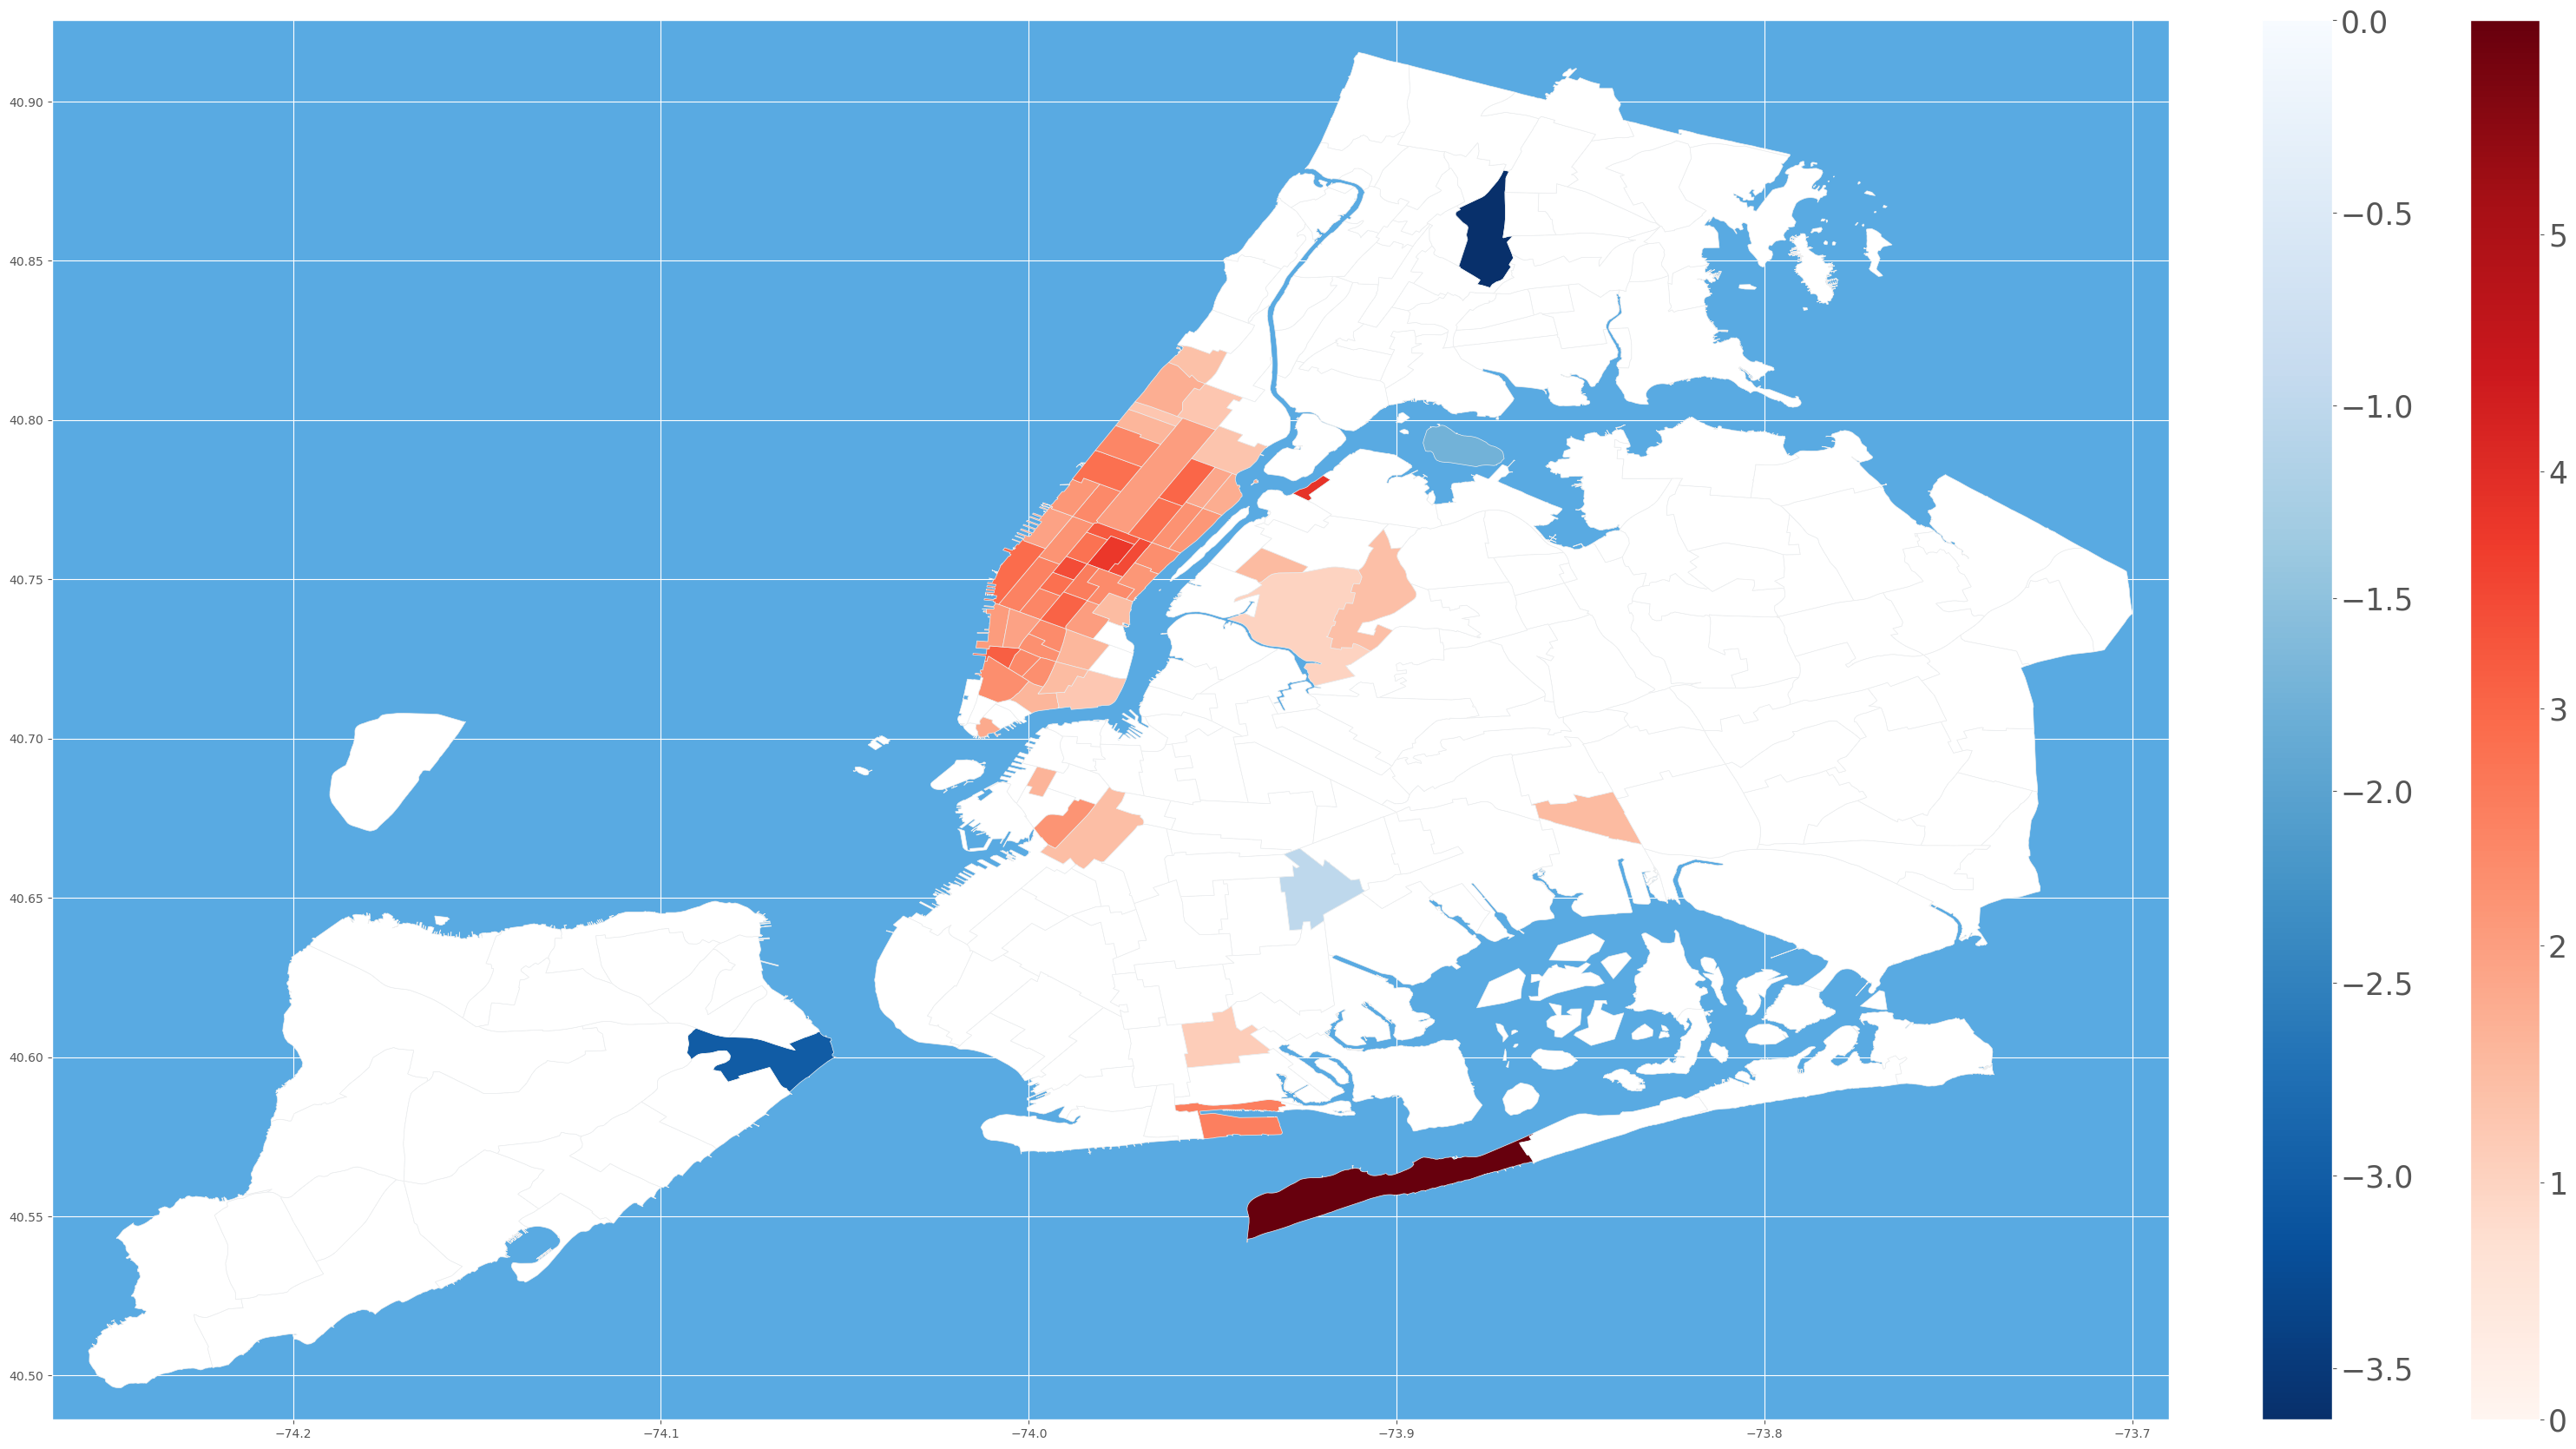

In [40]:
levels = ["PU"]
subsets = ["FHV"]
workday_split = "None"
daytime = "day"
month_fe = False
for level in levels:
        for subset in subsets:
                pooled_regression = pd.read_csv(f"Data/Pooled_data/{level}/final/final_data_{subset}_{level}.csv")
                # Load the data over 20 degrees and less than 25
                if subset == "FHV":
                        panel_data = pooled_regression[pooled_regression["tmax_obs"] >= 30].copy()
                        # panel_data = panel_data[panel_data["tmax_obs"]  >= 20]

                        # drop zone 105 - too little variation for poisson estimation
                        # panel_data = panel_data[panel_data["PULocationID"] != 105]

                        # cold - exclude strong positive resposne zones
                        # panel_data = panel_data[panel_data["PULocationID"] != 253]
                        #panel_data = panel_data[panel_data["PULocationID"] != 194]



                        
                if subset == "YG":
                        panel_data = panel_data[panel_data["Year_fact"] != 1]


                if daytime == "day":
                        # only include trips from 8 to 10 
                
                        panel_data['daytime_perc'] = panel_data['daytime_perc'].fillna(0)
                        panel_data["trip_number"] = panel_data["trip_number"]*panel_data["daytime_perc"]
                        panel_data["log_total"] = np.log(panel_data["trip_number"]+1)

 


                # Get unique PULocationIDs and apply the regression function to each
                unique_ids = panel_data[f'{level}LocationID'].unique()
                results = [run_zone_level_regression(panel_data, id, level, workday_split, month_fe = month_fe) for id in unique_ids]

                # Convert the results to a DataFrame
                results_df = pd.DataFrame(results)
                # only keep significant etimates
                sign = results_df[results_df["p_value_tmax_obs"] <= 0.1]
                

                # merge df of results subset with shape_dataframe for plotting ( significant at least at 10% level)
                plot_mobility_heat = sign.merge(df_loc[["borough", "location_i", "zone"]], left_on=f"{level}LocationID", right_on="location_i").drop(f"{level}LocationID", axis=1)
                plot_mobility_heat["Coefficient_tmax_obs"] = plot_mobility_heat["Coefficient_tmax_obs"] * 100

                top3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=False).set_index("location_i").head(3)
                bottom3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=True).set_index("location_i").head(3)

                # concatenate the top and bottom 3
                top_bottom = pd.concat([top3_sign, bottom3_sign])

                mobility_response = dict(zip(plot_mobility_heat['location_i'].tolist(), plot_mobility_heat['Coefficient_tmax_obs'].tolist()))

                # Create a 2x3 grid
                fig = plt.figure(figsize=(30, 25))  # Adjust the figure size as needed
                gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])  # Adjust height ratios if needed

                # Top plot spanning all columns in the first row
                ax = fig.add_subplot(gs[0, :])
                draw_zone_map(ax, sf, heat=mobility_response)

                plt.tight_layout()

In [ ]:
correlations = spearman_correlations(socioeconomic, plot_mobility_heat, positive = "positive")

##### 4. Plot correlations 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Color map and normalizer
cmap = plt.cm.coolwarm
norm = plt.Normalize(-1, 1)

# Spearman Correlations -- TStill have to enter correlations manually 
characteristics = {
    'Demographic': {
        'Median Income': 0.467672,
        'Median Age': 0.202721,
        'No Vehicles': 0.243288,
        'Federal Poverty 100': -0.506949,
        'Summertime Temperature': -0.226723,
        'Unemployed' : -0.496762,
        'Non-insured' : -0.617724,
    },
    'Commuting': {
        'Bicycle Commute': 0.244755,
        'Walking Commute': 0.426245,
        'Subway Commute': -0.309121,
        'Work from Home': 0.368783,
        'Taxi Commute': 0.465522,
        'Time to work' : -0.501254
    }
}

# Combine all characteristics into a single list without distinguishing groups
combined_characteristics = {**characteristics['Demographic'], **characteristics['Commuting']}

# Create plot
fig, ax = plt.subplots(figsize=(10, 8))

fig.set_facecolor('white')
ax.set_facecolor('white')

# Horizontal colorbar at the top
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', pad=0.1)
cbar.set_label('Spearman Correlation')

# Variables for plotting
bar_height = 0.4
y_counter = 0  # Counter for y-positions

# Plot each characteristic
for char, corr in combined_characteristics.items():
    # Determine color based on correlation
    color = cmap(norm(corr))
    
    # Plot the bar
    ax.barh(y_counter, corr, height=bar_height, color=color, align='center', edgecolor='black')
    
    # Label for the characteristic
    ax.text(-1, y_counter, char, ha='right', va='center', fontsize=10)
    
    # Increment y-position counter
    y_counter += 1

# Remove x and y axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Set limits and title
ax.set_xlim(-1, 1)


# Adjust layout manually if needed
fig.subplots_adjust(top=0.85, bottom=0.05, left=0.2, right=0.95)

plt.show()
